<!-- Project Title with Main Image -->
<div style="text-align: center; margin-top: 30px;">
    <h1 style="color: #2E7D32; font-family: 'Georgia', serif; border: none; padding: 20px; margin-top: 20px; display: block; background-color: transparent;">
        <i class="fa fa-paw" style="margin-right: 10px; font-size: 32px;"></i>
        Animal Image Classification Project
    </h1>
    <img src="https://img.freepik.com/free-vector/diagram-showing-food-web-rainforest_1308-61671.jpg?t=st=1722975703~exp=1722979303~hmac=2d45a1cb41f8499ac23bf6d682ca8feb3efecc24def6e8a0024360a7dee92a33&w=826" alt="Notebook Cover" style="width: 100%; max-width: 600px; border-radius: 10px;"/>
</div>

<!-- Import Libraries -->
<h2 style="color: #000; font-family: 'Georgia', serif; border: 1px solid #BDBDBD; padding: 10px; margin-top: 20px; display: flex; align-items: center; background-color: #F5F5F5; border-radius: 5px;">
    <i class="fa fa-code" style="margin-right: 10px;"></i>
    Import Libraries
</h2>

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Importing necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
import plotly.graph_objects as go
import plotly.express as px

In [2]:
# Paths to the dataset
dataset_path = "../../data/animals"
labels_file = "../../data/name of the animals.txt"

# Reading labels
with open(labels_file, 'r') as f:
    animal_names = f.read().split('\n')
    
# Display the first few animal names
animal_names[:10]

['antelope',
 'badger',
 'bat',
 'bear',
 'bee',
 'beetle',
 'bison',
 'boar',
 'butterfly',
 'cat']

<!-- EDA -->
<h2 style="color: #000; font-family: 'Georgia', serif; border: 1px solid #BDBDBD; padding: 10px; margin-top: 20px; display: flex; align-items: center; background-color: #F5F5F5; border-radius: 5px;">
    <i class="fa fa-chart-bar" style="margin-right: 10px;"></i>
    Exploratory Data Analysis (EDA)
</h2>

In [3]:
# Display distribution of animal classes
animal_counts = {animal: len(os.listdir(os.path.join(dataset_path, animal))) for animal in animal_names}
animal_counts_df = pd.DataFrame(list(animal_counts.items()), columns=['Animal', 'Count'])
animal_counts_df = animal_counts_df.sort_values(by='Count', ascending=False)

fig = px.bar(animal_counts_df, x='Animal', y='Count', title='Distribution of Animal Classes', labels={'Animal': 'Animal', 'Count': 'Number of Images'},
             color='Count', color_continuous_scale='Viridis', template='plotly_dark')
fig.update_layout(title_font_size=24, title_x=0.5, xaxis_title_font_size=18, yaxis_title_font_size=18, font=dict(family="Arial, sans-serif", size=14))
fig.show()

<!-- Data Preprocessing -->
<h2 style="color: #000; font-family: 'Georgia', serif; border: 1px solid #BDBDBD; padding: 10px; margin-top: 20px; display: flex; align-items: center; background-color: #F5F5F5; border-radius: 5px;">
    <i class="fa fa-cogs" style="margin-right: 10px;"></i>
    Data Preprocessing
</h2>

In [4]:
# Image Preprocessing using OpenCV
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.0
    return image

# Create dataset
data = []
labels = []

for animal in animal_names:
    animal_dir = os.path.join(dataset_path, animal)
    for img_name in os.listdir(animal_dir):
        img_path = os.path.join(animal_dir, img_name)
        data.append(preprocess_image(img_path))
        labels.append(animal)

data = np.array(data)
labels = np.array(labels)

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

<!-- Model Training -->
<h2 style="color: #000; font-family: 'Georgia', serif; border: 1px solid #BDBDBD; padding: 10px; margin-top: 20px; display: flex; align-items: center; background-color: #F5F5F5; border-radius: 5px;">
    <i class="fa fa-dumbbell" style="margin-right: 10px;"></i>
    Model Training
</h2>

In [5]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=23520945)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load the EfficientNetB3 model with pre-trained weights
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze some of the top layers of EfficientNetB3
for layer in base_model.layers[-50:]:  # Fine-tune top layers
    layer.trainable = True
    
# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(animal_names), activation='softmax')
])

model.summary()

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Compile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 7, 7, 1536)       10783535  
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 90)                46170     
                                                                 
Total params: 11,616,649
Trainable params: 11,529,346
Non-trainable params: 87,303
_______________________________________

In [6]:
import gc
del data
gc.collect()

1302

In [7]:
# Train the model with data augmentation and learning rate scheduling
history = model.fit(datagen.flow(X_train, y_train, batch_size=8), 
                    epochs=50, 
                    validation_data=(X_test, y_test),
                    callbacks=[lr_scheduler])

Epoch 1/50
540/540 [==============================] - 86s 133ms/step - loss: 3.5191 - accuracy: 0.2417 - val_loss: 4.5264 - val_accuracy: 0.0185 - lr: 1.0000e-04
Epoch 2/50
540/540 [==============================] - 67s 124ms/step - loss: 1.5063 - accuracy: 0.6248 - val_loss: 2.5030 - val_accuracy: 0.4287 - lr: 1.0000e-04
Epoch 3/50
540/540 [==============================] - 67s 125ms/step - loss: 0.8706 - accuracy: 0.7750 - val_loss: 2.0881 - val_accuracy: 0.4926 - lr: 1.0000e-04
Epoch 4/50
540/540 [==============================] - 67s 124ms/step - loss: 0.6247 - accuracy: 0.8306 - val_loss: 264.5581 - val_accuracy: 0.0102 - lr: 1.0000e-04
Epoch 5/50
540/540 [==============================] - 66s 123ms/step - loss: 0.4848 - accuracy: 0.8727 - val_loss: 286.2546 - val_accuracy: 0.0102 - lr: 1.0000e-04
Epoch 6/50
540/540 [==============================] - 67s 125ms/step - loss: 0.4070 - accuracy: 0.8940 - val_loss: 706.0832 - val_accuracy: 0.0102 - lr: 1.0000e-04
Epoch 7/50
540/540 [==

In [8]:
model.save_weights("../models/my_model_weights.h5")

<!-- Model Evaluation -->
<h2 style="color: #000; font-family: 'Georgia', serif; border: 1px solid #BDBDBD; padding: 10px; margin-top: 20px; display: flex; align-items: center; background-color: #F5F5F5; border-radius: 5px;">
    <i class="fa fa-clipboard-check" style="margin-right: 10px;"></i>
    Model Evaluation
</h2>

In [9]:
# Plot training history
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['accuracy'])+1)), y=history.history['accuracy'], mode='lines+markers', name='Training Accuracy'))
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['val_accuracy'])+1)), y=history.history['val_accuracy'], mode='lines+markers', name='Validation Accuracy'))
fig.update_layout(title='Model Accuracy', xaxis_title='Epoch', yaxis_title='Accuracy', title_font_size=24, title_x=0.5, xaxis_title_font_size=18, yaxis_title_font_size=18, font=dict(family="Arial, sans-serif", size=14), template='plotly_dark')
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['loss'])+1)), y=history.history['loss'], mode='lines+markers', name='Training Loss'))
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['val_loss'])+1)), y=history.history['val_loss'], mode='lines+markers', name='Validation Loss'))
fig.update_layout(title='Model Loss', xaxis_title='Epoch', yaxis_title='Loss', title_font_size=24, title_x=0.5, xaxis_title_font_size=18, yaxis_title_font_size=18, font=dict(family="Arial, sans-serif", size=14), template='plotly_dark')
fig.show()

In [10]:
del X_train, y_train, base_model, datagen
gc.collect()

X_test1 = X_test[:600]
y_test1 = y_test[:600]

del X_test, y_test
gc.collect()

# Evaluate model
y_pred = np.argmax(model.predict(X_test1), axis=-1)
print(classification_report(y_test1, y_pred, target_names=label_encoder.classes_))

19/19 [==============================] - 3s 101ms/step
                precision    recall  f1-score   support

      antelope       0.67      1.00      0.80         4
        badger       1.00      1.00      1.00         5
           bat       1.00      0.83      0.91         6
          bear       0.75      0.75      0.75         4
           bee       1.00      0.92      0.96        13
        beetle       1.00      1.00      1.00         7
         bison       0.60      1.00      0.75         3
          boar       1.00      1.00      1.00         6
     butterfly       0.88      1.00      0.93         7
           cat       1.00      1.00      1.00         4
   caterpillar       1.00      0.88      0.93         8
    chimpanzee       0.75      1.00      0.86         3
     cockroach       1.00      1.00      1.00         3
           cow       1.00      1.00      1.00         7
        coyote       0.88      1.00      0.93         7
          crab       1.00      1.00      1.00   

In [14]:
import os
import pickle

# Tạo thư mục nếu chưa tồn tại
os.makedirs('../models', exist_ok=True)

# Lưu history
with open('../models/training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)


In [18]:
import pickle
import plotly.graph_objects as go  # Cần dùng plotly để tạo Figure

# Load training history từ file .pkl
with open('../models/training_history.pkl', 'rb') as f:
    history_dict = pickle.load(f)

# Plot Accuracy
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=list(range(1, len(history_dict['accuracy']) + 1)),
    y=history_dict['accuracy'],
    mode='lines+markers',
    name='Training Accuracy'
))
fig.add_trace(go.Scatter(
    x=list(range(1, len(history_dict['val_accuracy']) + 1)),
    y=history_dict['val_accuracy'],
    mode='lines+markers',
    name='Validation Accuracy'
))
fig.update_layout(
    title='Model Accuracy',
    xaxis_title='Epoch',
    yaxis_title='Accuracy',
    title_font_size=24,
    title_x=0.5,
    xaxis_title_font_size=18,
    yaxis_title_font_size=18,
    font=dict(family="Arial, sans-serif", size=14),
    template='plotly_dark'
)
fig.show()

# Plot Loss
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=list(range(1, len(history_dict['loss']) + 1)),
    y=history_dict['loss'],
    mode='lines+markers',
    name='Training Loss'
))
fig.add_trace(go.Scatter(
    x=list(range(1, len(history_dict['val_loss']) + 1)),
    y=history_dict['val_loss'],
    mode='lines+markers',
    name='Validation Loss'
))
fig.update_layout(
    title='Model Loss',
    xaxis_title='Epoch',
    yaxis_title='Loss',
    title_font_size=24,
    title_x=0.5,
    xaxis_title_font_size=18,
    yaxis_title_font_size=18,
    font=dict(family="Arial, sans-serif", size=14),
    template='plotly_dark'
)
fig.show()


<!-- Sample Predictions -->
<h2 style="color: #000; font-family: 'Georgia', serif; border: 1px solid #BDBDBD; padding: 10px; margin-top: 20px; display: flex; align-items: center; background-color: #F5F5F5; border-radius: 5px;">
    <i class="fa fa-image" style="margin-right: 10px;"></i>
    Sample Predictions
</h2>

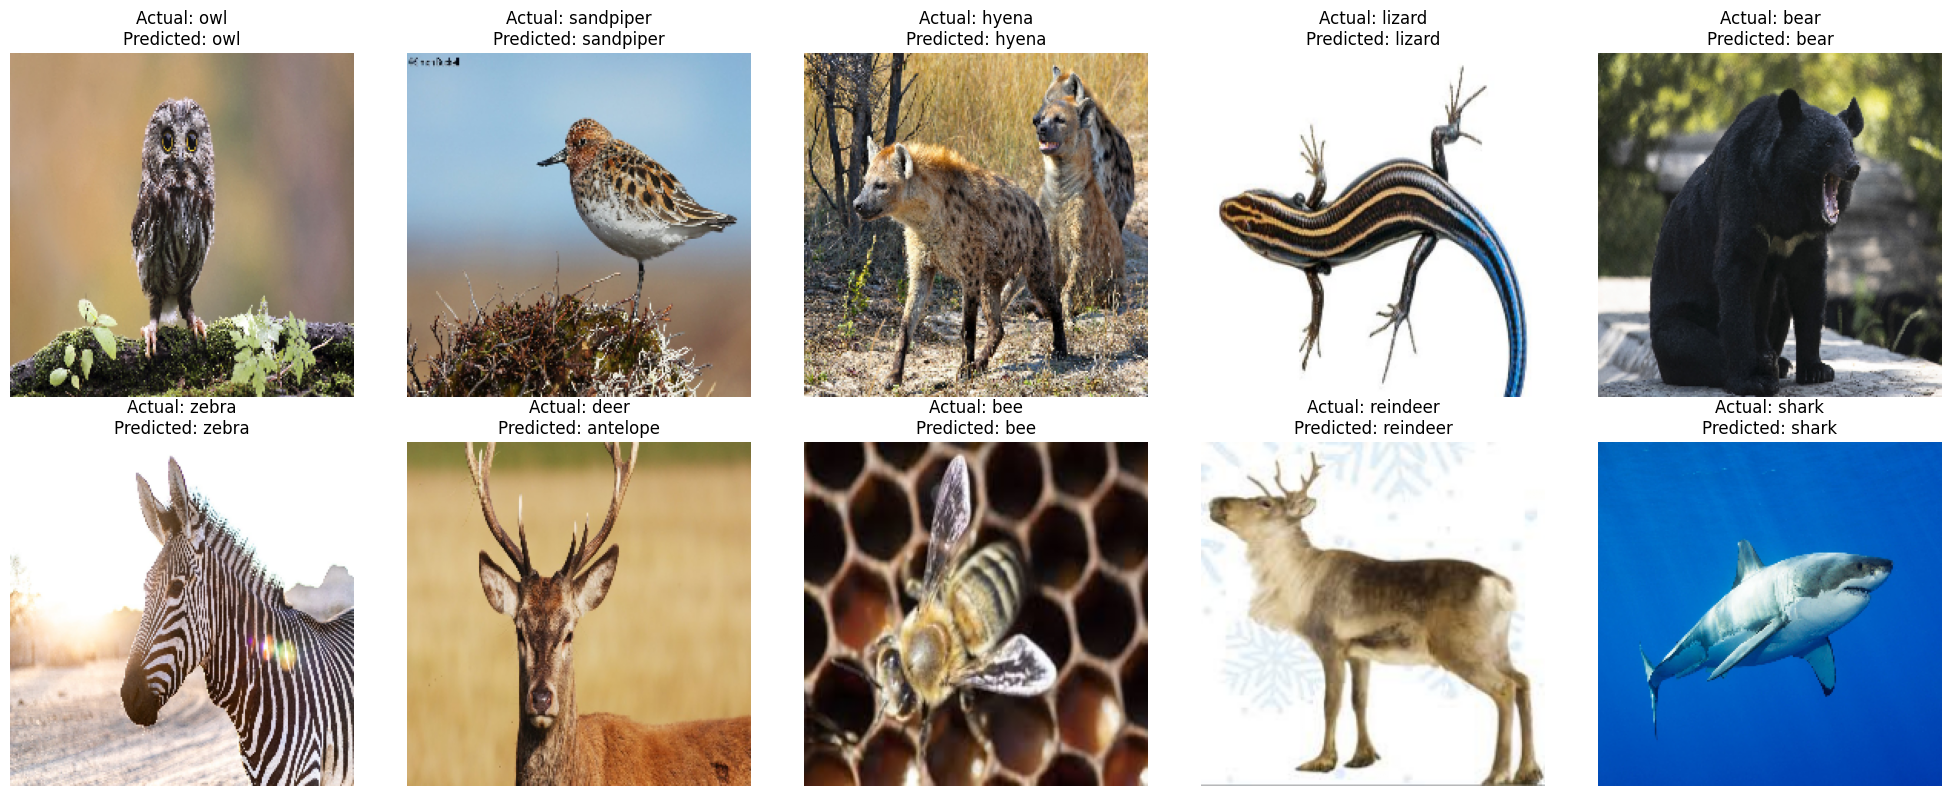

In [11]:
# Display sample predictions
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(X_test1[i])
    ax.axis('off')
    ax.set_title(f'Actual: {label_encoder.inverse_transform([y_test1[i]])[0]}\nPredicted: {label_encoder.inverse_transform([y_pred[i]])[0]}')
plt.tight_layout()
plt.show()

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Importing necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
import plotly.graph_objects as go
import plotly.express as px

In [2]:
# Paths to the dataset
dataset_path = "../../data/animals"
labels_file = "../../data/name of the animals.txt"
# Reading labels
with open(labels_file, 'r') as f:
    animal_names = f.read().split('\n')
    
# Display the first few animal names
print(animal_names[:10])

# Display distribution of animal classes
animal_counts = {animal: len(os.listdir(os.path.join(dataset_path, animal))) for animal in animal_names}
animal_counts_df = pd.DataFrame(list(animal_counts.items()), columns=['Animal', 'Count'])
animal_counts_df = animal_counts_df.sort_values(by='Count', ascending=False)

fig = px.bar(animal_counts_df, x='Animal', y='Count', title='Distribution of Animal Classes', labels={'Animal': 'Animal', 'Count': 'Number of Images'},
             color='Count', color_continuous_scale='Viridis', template='plotly_dark')
fig.update_layout(title_font_size=24, title_x=0.5, xaxis_title_font_size=18, yaxis_title_font_size=18, font=dict(family="Arial, sans-serif", size=14))
fig.show()

# Image Preprocessing using OpenCV
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.0
    return image

# Create dataset
data = []
labels = []

for animal in animal_names:
    animal_dir = os.path.join(dataset_path, animal)
    for img_name in os.listdir(animal_dir):
        img_path = os.path.join(animal_dir, img_name)
        data.append(preprocess_image(img_path))
        labels.append(animal)

data = np.array(data)
labels = np.array(labels)

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=12345)

['antelope', 'badger', 'bat', 'bear', 'bee', 'beetle', 'bison', 'boar', 'butterfly', 'cat']


In [3]:
# Build the same model again
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers[-50:]:
    layer.trainable = True

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(animal_names), activation='softmax')  # same output shape!
])

# Compile (only needed for predict if model uses certain layers)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# Load weights
model.load_weights("../../my_model_weights.h5")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 7, 7, 1536)       10783535  
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 90)                46170     
                                                                 
Total params: 11,616,649
Trainable params: 11,529,346
Non-trainable params: 87,303
_______________________________________

34/34 [==============================] - 12s 100ms/step
                precision    recall  f1-score   support

      antelope       0.92      1.00      0.96        11
        badger       1.00      1.00      1.00        14
           bat       1.00      1.00      1.00        19
          bear       1.00      1.00      1.00        11
           bee       1.00      0.95      0.97        19
        beetle       1.00      1.00      1.00        15
         bison       0.93      1.00      0.97        14
          boar       1.00      1.00      1.00        17
     butterfly       1.00      1.00      1.00         8
           cat       1.00      1.00      1.00         7
   caterpillar       1.00      0.94      0.97        18
    chimpanzee       1.00      1.00      1.00        13
     cockroach       1.00      1.00      1.00        11
           cow       0.90      1.00      0.95         9
        coyote       1.00      1.00      1.00         9
          crab       1.00      1.00      1.00  

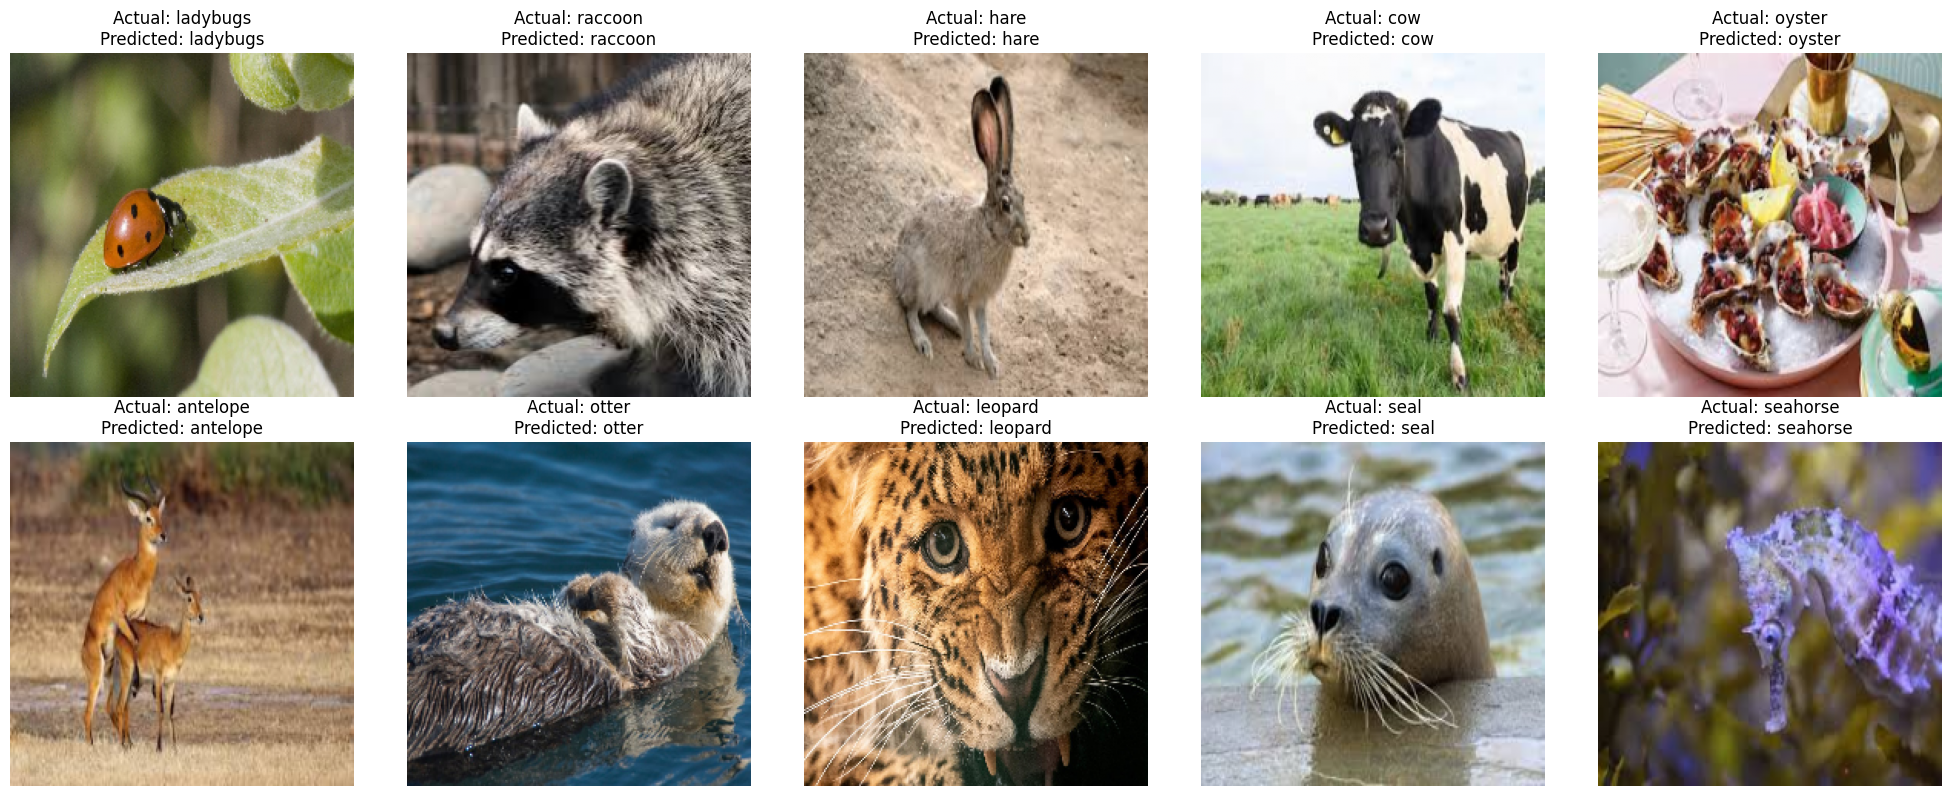

In [4]:
import gc
del data
del X_train, y_train, base_model

gc.collect()

# Evaluate model
y_pred = np.argmax(model.predict(X_test), axis=-1)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


# Display sample predictions
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(X_test[i])
    ax.axis('off')
    ax.set_title(f'Actual: {label_encoder.inverse_transform([y_test[i]])[0]}\nPredicted: {label_encoder.inverse_transform([y_pred[i]])[0]}')
plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 62ms/step


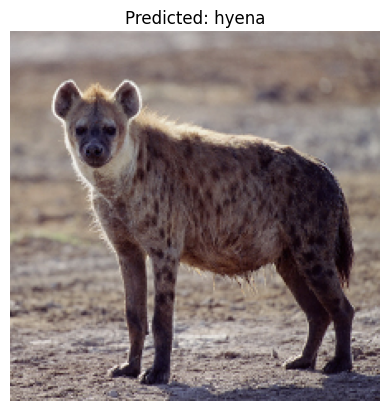

Predicted animal: hyena


In [5]:
def predict_image(image_path, model, label_encoder):
    # Tiền xử lý ảnh giống như ảnh trong tập huấn luyện
    image = preprocess_image(image_path)
    image = np.expand_dims(image, axis=0)  # Thêm batch dimension

    # Dự đoán
    prediction = model.predict(image)
    predicted_class = np.argmax(prediction, axis=-1)[0]
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]

    # Hiển thị kết quả
    plt.imshow(image[0])
    plt.title(f"Predicted: {predicted_label}")
    plt.axis("off")
    plt.show()

    return predicted_label
image_path = "../images/hyena.jpg"  # Đường dẫn ảnh bạn muốn test
predicted_label = predict_image(image_path, model, label_encoder)
print("Predicted animal:", predicted_label)

<div style="background: linear-gradient(135deg, #f5f7fa 0%, #c3cfe2 100%); padding: 20px; border-radius: 15px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1); text-align: center;">
    <h2 style="color: #2c3e50; font-family: 'Lucida Bright', Georgia, serif; font-size: 28px; margin-bottom: 10px;">
        👍 Enjoyed the Notebook?
    </h2>
    <p style="font-family: 'Arial', sans-serif; font-size: 18px; color: #34495e; margin-bottom: 20px;">
        Please consider <span style="font-weight: bold; color: #e74c3c;">upvoting</span> to show your support!
    </p>
    <p style="font-family: 'Courier New', monospace; font-size: 16px; color: #7f8c8d;">
        Your feedback inspires me to create more insightful content. Thank you!
    </p>
</div>